### MMD - Critic

Acknowledgement;  This notebook is adjusted from excellent code provided by https://github.com/maxidl/MMD-critic and also the original authors of MMD-critic https://github.com/BeenKim/MMD-critic

In [1]:
import sys
print(sys.executable)

C:\Users\eoind\Anaconda3\envs\mmd-critic\python.exe


In [2]:
import math
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from mmd_critic import Dataset, select_prototypes, select_criticisms
import numpy as np

In [3]:
cwd = Path('.')

In [4]:
from torchvision import transforms

transform_1 = transforms.Compose([transforms.ToTensor()])

In [5]:
mnist_data = datasets.MNIST('./data/', download=True, train=True, transform = transform_1)
ds = mnist_data

In [6]:
class_name = '7 - seven'

In [7]:
class_idx = ds.class_to_idx[class_name]
ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])
dl = torch.utils.data.DataLoader(ds, batch_size=64)

C:\Users\eoind\AppData\Local\Temp\ipykernel_10136\396211549.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])


In [8]:
dataiter = iter(dl) # creating a iterator
images, labels = dataiter.next()

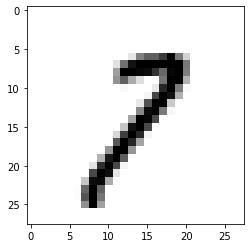

In [9]:
plt.imshow(images[63].numpy().squeeze(), cmap='gray_r');


In [10]:
def prototype_generator_mmd_pixel(class_label):

    cwd = Path('.')
    output_dir = cwd / 'output'
    #imagenet_root = Path('~/ILSVRC2012/')
    mnist_root = Path('./data/MNIST/')
    split='train'
    device = torch.device('cpu')


    gamma = None

    num_prototypes = 200
    num_criticisms = 20

    kernel_type = 'local'
    # kernel_type = 'global'

    # regularizer = None
    regularizer = 'logdet'
    # regularizer = 'iterative'
    use_image_embeddings = False
    batch_size = 64

    make_plots = False
    
    class_name = class_label

    print('==============')
    #print(f'imagenet_root:{imagenet_root.absolute()}')
    print(f'output_dir:{output_dir.absolute()}')
    print(f'target_class:{class_name}')
    print(f'num_prototypes:{num_prototypes}')
    print(f'num_criticisms:{num_criticisms}')
    print(f'gamma:{gamma}')
    print(f'kernel_type:{kernel_type}')
    print(f'regularizer:{regularizer}')
    print(f'make_plots:{make_plots}')
    print('==============\n')

    # torch.set_num_threads(64)

    class_name = class_label

    ds = datasets.MNIST('./data/', download=True, train=True, transform = transform_1)
    class_idx = ds.class_to_idx[class_name]
    ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])
    samples = [sample[0] for sample in ds]

    X = torch.stack(samples).reshape(len(samples), -1)
    y = torch.zeros((X.shape[0],), dtype=torch.long)

    d = Dataset(X, y)
    if kernel_type == 'global':
        d.compute_rbf_kernel(gamma)
    elif kernel_type == 'local':
        d.compute_local_rbf_kernel(gamma)
    else:
        raise KeyError('kernel_type must be either "global" or "local"')
    print('Done.', flush=True)
    class_name = class_name.replace(' ', '_')

    # Prototypes
    if num_prototypes > 0:
        print('Computing prototypes...', end='', flush=True)
        prototype_indices = select_prototypes(d.K, num_prototypes)

        prototypes = d.X[prototype_indices]
        prototype_labels = d.y[prototype_indices]

        sorted_by_y_indices = prototype_labels.argsort()
        prototypes_sorted = prototypes[sorted_by_y_indices]
        prototype_labels = prototype_labels[sorted_by_y_indices]
        print('Done.', flush=True)
        print(prototype_indices.sort()[0].tolist())

        # Visualize
        if make_plots:
            print('Plotting prototypes...', end='', flush=True)
            num_cols = 8
            num_rows = math.ceil(num_prototypes / num_cols)
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
            for i, axis in enumerate(axes.ravel()):
                if i >= num_prototypes:
                    axis.axis('off')
                    continue
                axis.imshow(prototypes_sorted[i].view(1,28,28).permute(1,2,0).numpy())
                axis.axis('off')
            fig.suptitle(f'{num_prototypes} Prototypes')
            plt.savefig(output_dir / f'{num_prototypes}_prototypes_imagenet_{class_name}.svg')
            print('Done.', flush=True)

        # Criticisms
        if num_criticisms > 0:
            print('Computing criticisms...', end='', flush=True)
            criticism_indices = select_criticisms(d.K, prototype_indices, num_criticisms, regularizer)

            criticisms = d.X[criticism_indices]
            criticism_labels = d.y[criticism_indices]

            sorted_by_y_indices = criticism_labels.argsort()
            criticisms_sorted = criticisms[sorted_by_y_indices]
            criticism_labels = criticism_labels[sorted_by_y_indices]
            print('Done.', flush=True)
            print(criticism_indices.sort()[0].tolist())

            # Visualize
            if make_plots:
                print('Plotting criticisms...', end='', flush=True)
                num_cols = 8
                num_rows = math.ceil(num_criticisms / num_cols)
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
                for i, axis in enumerate(axes.ravel()):
                    if i >= num_criticisms:
                        axis.axis('off')
                        continue
                    axis.imshow(criticisms_sorted[i].view(1,28,28).permute(1,2,0).numpy())
                    axis.axis('off')
                fig.suptitle(f'{num_criticisms} Criticisms')
                plt.savefig(output_dir / f'{num_criticisms}_criticisms_imagenet_{class_name}.svg')
                print('Done.', flush=True)
                
        return prototype_indices.numpy(), criticism_indices.numpy()


In [11]:
prototype_indices, criticism_indices = prototype_generator_mmd_pixel('7 - seven')

output_dir:C:\Users\eoind\MMD-critic\output
target_class:7 - seven
num_prototypes:200
num_criticisms:20
gamma:None
kernel_type:local
regularizer:logdet
make_plots:False



C:\Users\eoind\AppData\Local\Temp\ipykernel_10136\255537365.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])


Setting default gamma=0.0012755102040816326
Done.
Computing prototypes...Done.
[34, 38, 119, 130, 138, 176, 183, 197, 218, 219, 228, 272, 294, 350, 390, 421, 454, 462, 484, 509, 518, 551, 554, 564, 567, 593, 626, 653, 691, 715, 738, 748, 762, 792, 795, 830, 861, 946, 961, 1046, 1077, 1176, 1199, 1251, 1274, 1313, 1398, 1423, 1424, 1506, 1537, 1541, 1544, 1556, 1583, 1610, 1653, 1703, 1732, 1769, 1809, 1811, 1838, 1856, 1900, 1908, 1911, 1951, 1976, 1994, 2012, 2063, 2220, 2221, 2271, 2352, 2447, 2464, 2543, 2610, 2680, 2694, 2722, 2742, 2789, 2803, 2809, 2826, 2852, 2891, 2935, 2960, 2976, 2984, 3019, 3064, 3102, 3189, 3220, 3224, 3250, 3252, 3257, 3321, 3323, 3364, 3392, 3397, 3446, 3464, 3487, 3500, 3538, 3570, 3590, 3594, 3598, 3664, 3681, 3699, 3714, 3773, 3797, 3818, 3821, 3836, 3885, 3899, 3924, 3935, 3978, 4031, 4101, 4113, 4143, 4158, 4186, 4190, 4243, 4267, 4281, 4360, 4368, 4408, 4412, 4553, 4557, 4605, 4648, 4657, 4665, 4680, 4690, 4727, 4774, 4791, 4832, 4842, 4849, 4853, 4

In [12]:
prototype_indices, criticism_indices

(array([2722, 1610, 4031, 4158, 1811,  272, 2352, 5753, 4832,  567, 2960,
        3397,  792, 4190,  830, 6165, 1994, 4267, 1911, 6113, 5834, 2680,
         218, 3797,  795, 1251, 3699, 5281, 5985, 1537, 5471, 5515, 5755,
        3189, 5896, 4657, 5603, 2012, 3392, 4842,   34, 1583, 3064, 3500,
        1506, 2742,  176, 4849, 5597, 5443, 2220,  294, 1176, 1398,  564,
        5648, 1900, 3224, 4557, 1703, 5680, 4690,  390, 1653, 1541,   38,
         484, 3681, 6198, 3364, 1838, 3487, 3978, 2789, 4680, 5074, 1423,
        1046, 2809, 1556, 4553, 1951, 2447, 4360, 4101, 5969, 3446,  626,
        4999, 4412,  462, 5301, 5511,  454, 1769, 2464, 1274,  518, 5358,
         551, 3590, 4665,  653, 3821, 4281,  762, 6019, 1976, 3570,  961,
        1313, 6070, 5166, 4408, 1908, 1732, 4727,  183, 4113, 2063, 3464,
        5639, 6209, 3836,  946, 4791, 2976, 4243, 2271, 4648,  421, 5396,
        5326, 5063,  219, 4774, 2221,  738,  197, 3773, 4143, 3252, 4853,
        3714, 5220, 2891,  861,  554, 

Converting data back to numpy; 

In [13]:
prototype_indices = []
criticism_indices = []

for class_label in ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
                    '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']:
    
    
    p, c = prototype_generator_mmd_pixel(class_label)
    
    prototype_indices.append(p)
    criticism_indices.append(c)
    
    
    
    



output_dir:C:\Users\eoind\MMD-critic\output
target_class:0 - zero
num_prototypes:200
num_criticisms:20
gamma:None
kernel_type:local
regularizer:logdet
make_plots:False



C:\Users\eoind\AppData\Local\Temp\ipykernel_10136\255537365.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])


Setting default gamma=0.0012755102040816326
Done.
Computing prototypes...Done.
[14, 111, 115, 138, 139, 179, 192, 215, 223, 230, 241, 271, 366, 376, 403, 441, 465, 519, 544, 580, 598, 686, 713, 733, 747, 768, 786, 818, 862, 888, 940, 944, 951, 972, 1020, 1076, 1159, 1168, 1192, 1296, 1353, 1373, 1379, 1422, 1428, 1439, 1468, 1551, 1555, 1608, 1627, 1645, 1658, 1666, 1685, 1694, 1757, 1761, 1771, 1791, 1837, 1904, 2021, 2022, 2072, 2115, 2117, 2154, 2188, 2332, 2335, 2361, 2370, 2404, 2410, 2432, 2482, 2489, 2514, 2578, 2647, 2706, 2718, 2728, 2763, 2812, 2838, 2841, 2868, 2937, 2938, 3031, 3039, 3044, 3073, 3076, 3102, 3116, 3136, 3185, 3190, 3234, 3270, 3356, 3408, 3472, 3474, 3500, 3505, 3534, 3554, 3556, 3568, 3569, 3576, 3617, 3641, 3650, 3689, 3721, 3739, 3742, 3753, 3779, 3805, 3813, 3819, 3823, 3847, 3859, 3914, 3945, 3962, 4010, 4022, 4055, 4075, 4174, 4186, 4292, 4323, 4388, 4395, 4458, 4487, 4492, 4527, 4530, 4533, 4550, 4582, 4611, 4622, 4629, 4634, 4644, 4660, 4678, 4726, 4

Computing criticisms...Done.
[204, 304, 886, 1761, 1770, 1826, 1956, 2258, 2301, 2471, 2920, 2988, 3203, 4180, 4481, 4494, 4917, 5013, 5019, 5398]
output_dir:C:\Users\eoind\MMD-critic\output
target_class:6 - six
num_prototypes:200
num_criticisms:20
gamma:None
kernel_type:local
regularizer:logdet
make_plots:False

Setting default gamma=0.0012755102040816326
Done.
Computing prototypes...Done.
[44, 71, 132, 217, 336, 357, 431, 438, 440, 450, 478, 538, 542, 562, 572, 589, 597, 603, 658, 660, 679, 705, 733, 747, 777, 787, 805, 909, 971, 981, 990, 1015, 1049, 1074, 1083, 1102, 1135, 1164, 1181, 1230, 1280, 1359, 1380, 1410, 1464, 1485, 1522, 1537, 1539, 1563, 1593, 1628, 1662, 1670, 1676, 1742, 1745, 1808, 1830, 1845, 1865, 1888, 1914, 1916, 1936, 1940, 1969, 1990, 2003, 2045, 2080, 2146, 2150, 2162, 2209, 2284, 2296, 2313, 2376, 2450, 2493, 2541, 2543, 2569, 2585, 2590, 2602, 2621, 2634, 2672, 2693, 2709, 2727, 2736, 2787, 2811, 2846, 2874, 2916, 2981, 3007, 3036, 3043, 3058, 3103, 3152, 31

In [14]:
np.array(prototype_indices).shape

#10 prototypes, one for each class

(10, 200)

In [15]:
np.array(criticism_indices).shape

(10, 20)

In [16]:
#np.save('prototype_indices_mmd_pixel_local.npy', np.array(prototype_indices))
#np.save('criticism_indices_mmd_pixel_local.npy', np.array(criticism_indices))

In [17]:
#np.save('prototype_indices_mmd_pixel_local_200.npy', np.array(prototype_indices))
#np.save('criticism_indices_mmd_pixel_local_20.npy', np.array(criticism_indices))

output_dir:C:\Users\eoind\MMD-critic\output
target_class:9 - nine
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True



C:\Users\eoind\AppData\Local\Temp\ipykernel_10136\2148838526.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])


Setting default gamma=0.0012755102040816326
Done.
Computing prototypes...Done.
[179, 259, 1189, 1294, 1556, 1813, 2047, 3341, 3980, 5607]
Plotting prototypes...Done.
Computing criticisms...Done.
[457, 1104, 1225, 1473, 1860, 2634, 3517, 3893, 4448, 5511]
Plotting criticisms...Done.


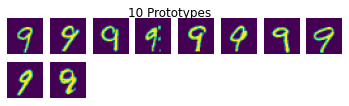

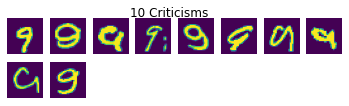

In [18]:

    cwd = Path('.')
    output_dir = cwd / 'output'
    #imagenet_root = Path('~/ILSVRC2012/')
    mnist_root = Path('./data/MNIST/')
    split='train'
    device = torch.device('cpu')
    
    class_label = '9 - nine'


    gamma = None

    num_prototypes = 10
    num_criticisms = 10

    kernel_type = 'local'
    # kernel_type = 'global'

    # regularizer = None
    regularizer = 'logdet'
    # regularizer = 'iterative'
    use_image_embeddings = False
    batch_size = 64

    make_plots = True
    
    class_name = class_label

    print('==============')
    #print(f'imagenet_root:{imagenet_root.absolute()}')
    print(f'output_dir:{output_dir.absolute()}')
    print(f'target_class:{class_name}')
    print(f'num_prototypes:{num_prototypes}')
    print(f'num_criticisms:{num_criticisms}')
    print(f'gamma:{gamma}')
    print(f'kernel_type:{kernel_type}')
    print(f'regularizer:{regularizer}')
    print(f'make_plots:{make_plots}')
    print('==============\n')

    # torch.set_num_threads(64)

    class_name = class_label

    ds = datasets.MNIST('./data/', download=True, train=True, transform = transform_1)
    class_idx = ds.class_to_idx[class_name]
    ds = torch.utils.data.Subset(ds, torch.where(torch.tensor(ds.targets) == class_idx)[0])
    samples = [sample[0] for sample in ds]

    X = torch.stack(samples).reshape(len(samples), -1)
    y = torch.zeros((X.shape[0],), dtype=torch.long)

    d = Dataset(X, y)
    if kernel_type == 'global':
        d.compute_rbf_kernel(gamma)
    elif kernel_type == 'local':
        d.compute_local_rbf_kernel(gamma)
    else:
        raise KeyError('kernel_type must be either "global" or "local"')
    print('Done.', flush=True)
    class_name = class_name.replace(' ', '_')

    # Prototypes
    if num_prototypes > 0:
        print('Computing prototypes...', end='', flush=True)
        prototype_indices = select_prototypes(d.K, num_prototypes)

        prototypes = d.X[prototype_indices]
        prototype_labels = d.y[prototype_indices]

        sorted_by_y_indices = prototype_labels.argsort()
        prototypes_sorted = prototypes[sorted_by_y_indices]
        prototype_labels = prototype_labels[sorted_by_y_indices]
        print('Done.', flush=True)
        print(prototype_indices.sort()[0].tolist())

        # Visualize
        if make_plots:
            print('Plotting prototypes...', end='', flush=True)
            num_cols = 8
            num_rows = math.ceil(num_prototypes / num_cols)
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
            for i, axis in enumerate(axes.ravel()):
                if i >= num_prototypes:
                    axis.axis('off')
                    continue
                axis.imshow(prototypes_sorted[i].view(1,28,28).permute(1,2,0).numpy())
                axis.axis('off')
            fig.suptitle(f'{num_prototypes} Prototypes')
            plt.savefig(output_dir / f'{num_prototypes}_prototypes_imagenet_{class_name}.svg')
            print('Done.', flush=True)

        # Criticisms
        if num_criticisms > 0:
            print('Computing criticisms...', end='', flush=True)
            criticism_indices = select_criticisms(d.K, prototype_indices, num_criticisms, regularizer)

            criticisms = d.X[criticism_indices]
            criticism_labels = d.y[criticism_indices]

            sorted_by_y_indices = criticism_labels.argsort()
            criticisms_sorted = criticisms[sorted_by_y_indices]
            criticism_labels = criticism_labels[sorted_by_y_indices]
            print('Done.', flush=True)
            print(criticism_indices.sort()[0].tolist())

            # Visualize
            if make_plots:
                print('Plotting criticisms...', end='', flush=True)
                num_cols = 8
                num_rows = math.ceil(num_criticisms / num_cols)
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
                for i, axis in enumerate(axes.ravel()):
                    if i >= num_criticisms:
                        axis.axis('off')
                        continue
                    axis.imshow(criticisms_sorted[i].view(1,28,28).permute(1,2,0).numpy())
                    axis.axis('off')
                fig.suptitle(f'{num_criticisms} Criticisms')
                plt.savefig(output_dir / f'{num_criticisms}_criticisms_imagenet_{class_name}.svg')
                print('Done.', flush=True)

In [19]:
prototype_indices

tensor([ 179,  259, 1189, 5607, 1294, 1556, 3980, 2047, 1813, 3341])